In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# funsgi 
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


def plot_rgb(image):
    plt.figure(figsize=(10,10))
    # plt.axis('off')
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



def plot_gray(image):
    plt.figure(figsize=(10,10))
    # plt.axis('off')
    return plt.imshow(image, cmap='Greys_r')

# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)


def get_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        # and the size is not too big
        if len(approx) == 4 and cv2.contourArea(c) < 700000 and cv2.contourArea(c) > 10000:
            print(cv2.contourArea(c))
            return approx

def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


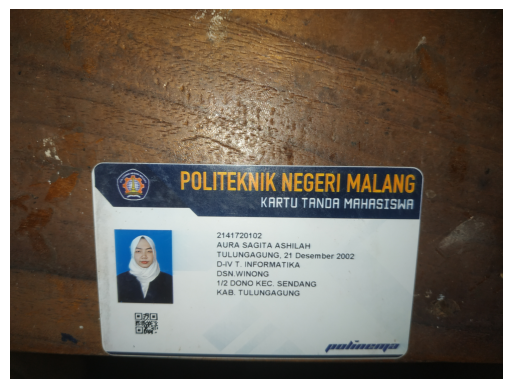

In [3]:
image = cv2.imread('ktms/37.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

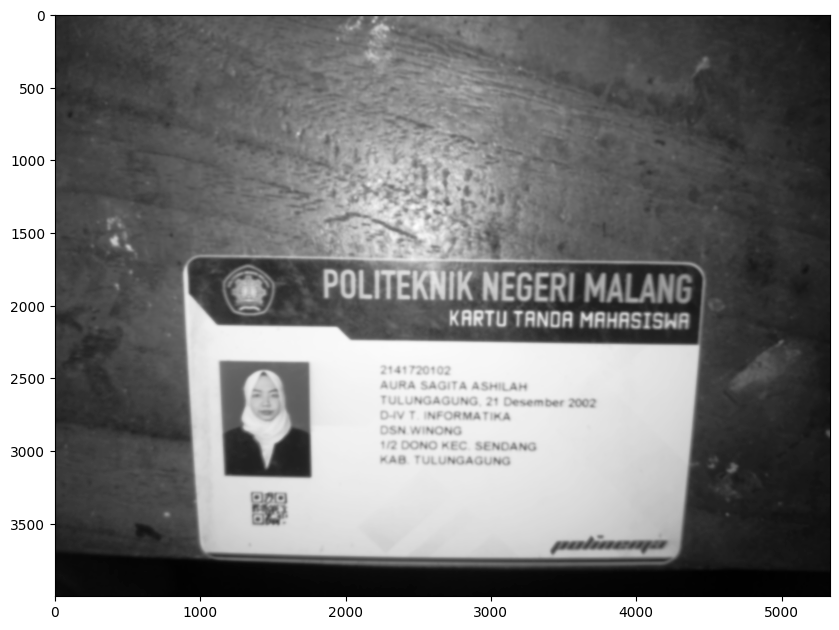

In [4]:
#downscale untuk mempercepat proses
resize_ratio = 4000 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# hilangkan noise
blurred = cv2.GaussianBlur(gray, (51, 51), 0)
plot_gray(blurred)

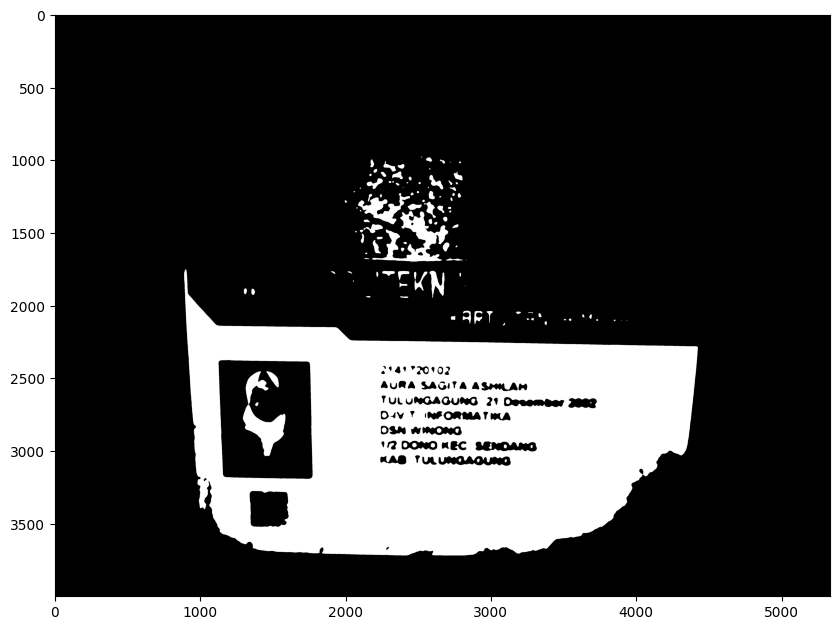

In [5]:
# thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(blurred, 170, 255, cv2.THRESH_BINARY)[1]
plot_gray(thresh)

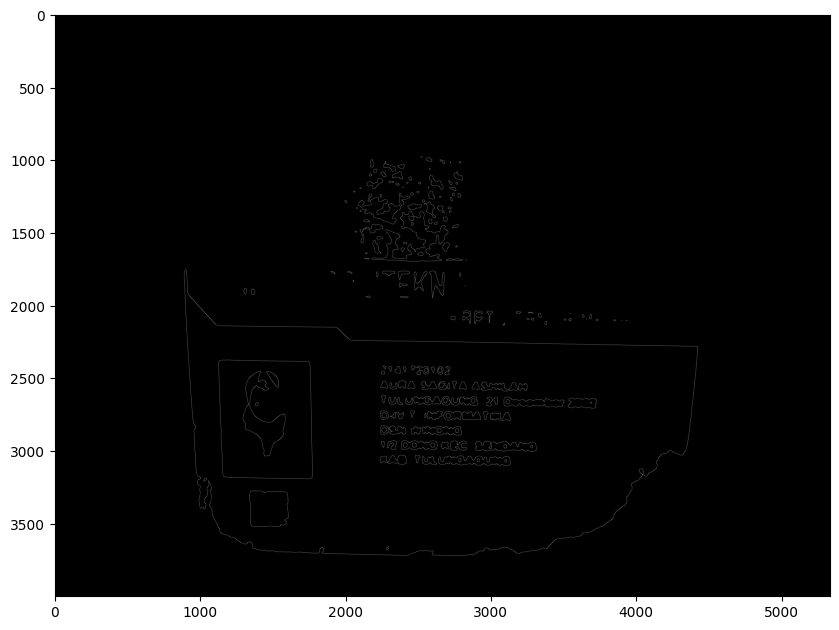

In [6]:
edged = cv2.Canny(thresh, 100, 200, apertureSize=3)
plot_gray(edged)

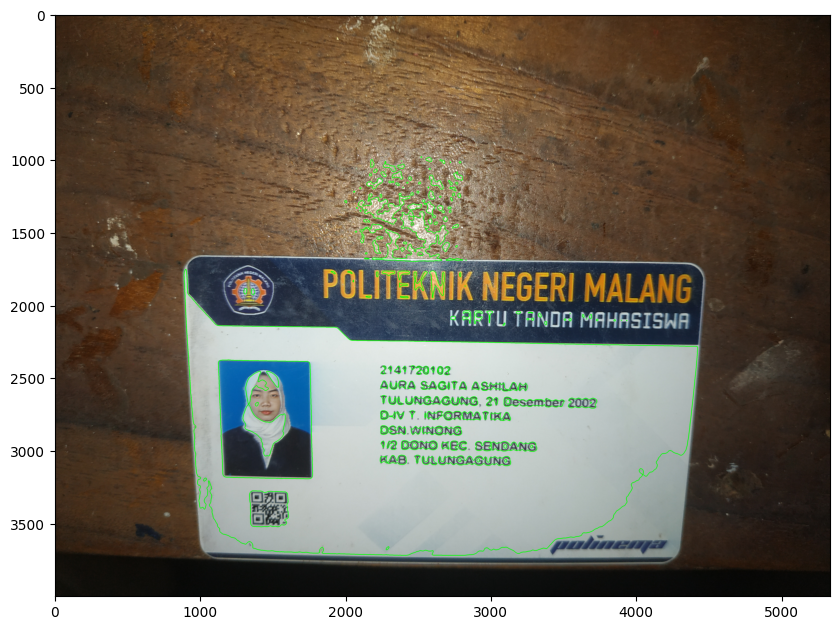

In [7]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

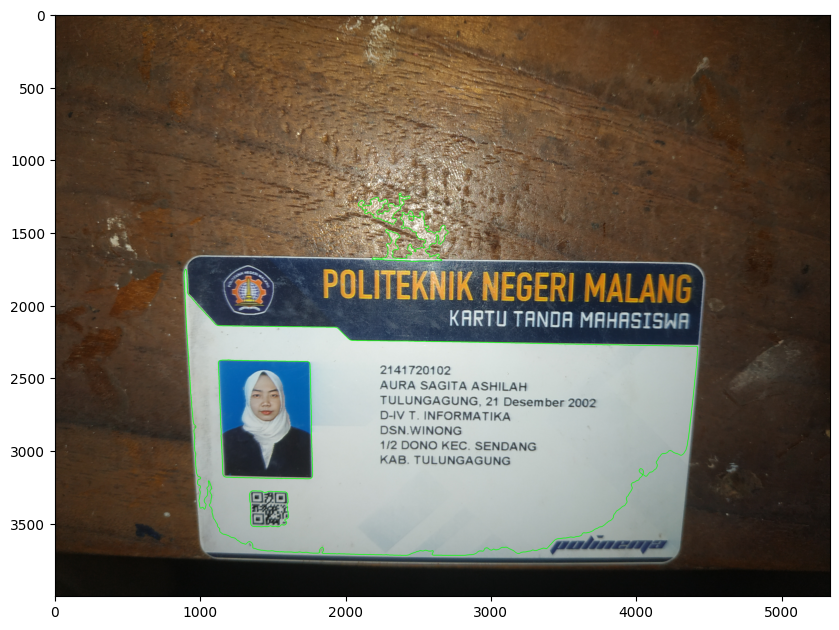

In [8]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

502965.0


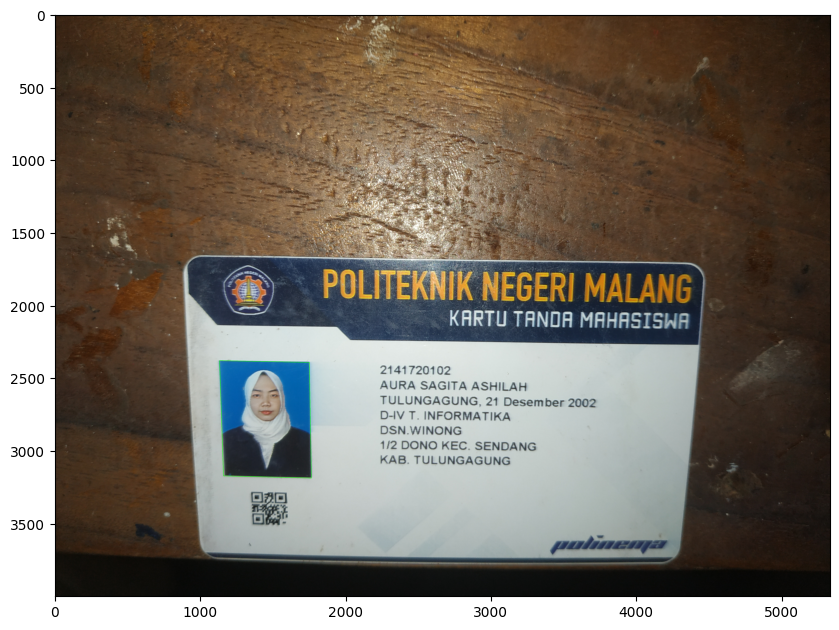

In [9]:
receipt_contour = get_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

(<Axes: title={'center': 'Output'}>,
 Text(0.5, 1.0, 'Output'))

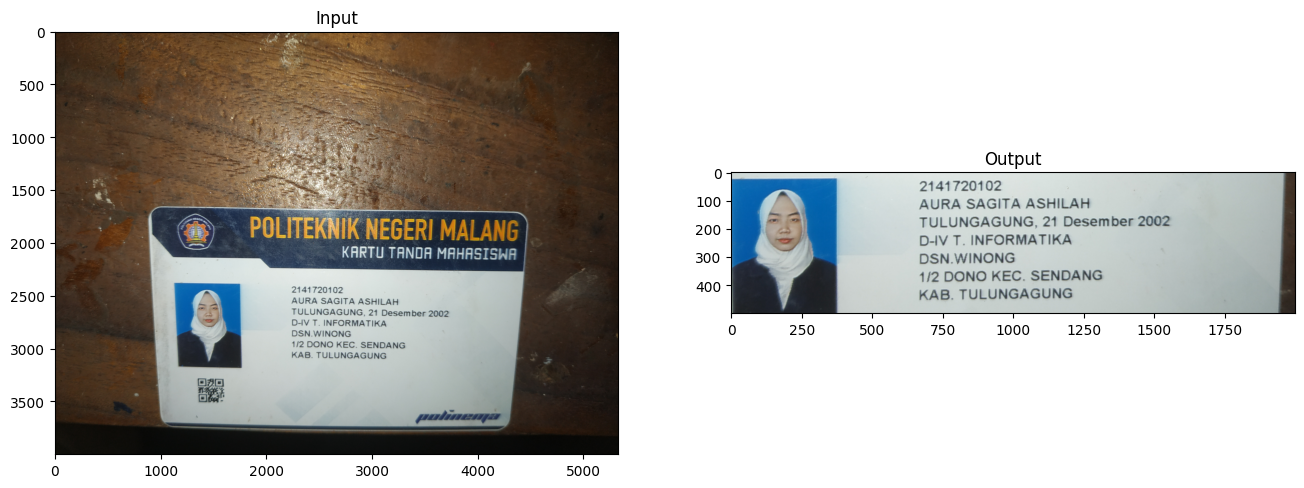

In [10]:
rect = contour_to_rect(receipt_contour)
pts1 = np.float32(rect)
# pts2 = np.float32([[375,25],[375,525],[0,525],[0,25]])
# pts2 = np.float32([[0,525],[0,25],[375,25],[375,525]])
pts2 = np.float32([[0, 25], [375, 25], [375, 525], [0, 525]])
# pts2 = np.float32([[100, 400], [475, 400], [475, 900], [100, 900]])
# pts2 = np.float32([[375, 525], [0, 525], [0, 25], [375, 25]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(image,M,(2000,500))

plt.figure(figsize=(16,10))
plt.subplot(121),plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)),plt.title('Input')
plt.subplot(122),plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title('Output')

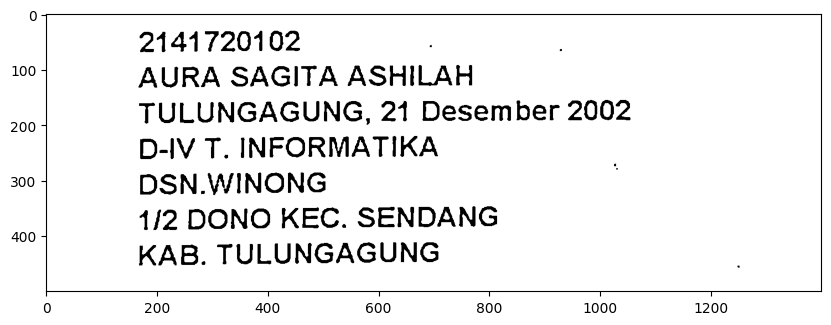

In [21]:
text_area = dst[0:800, 500:1900]
gray_text = cv2.cvtColor(text_area, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray_text, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
gray_text = cv2.GaussianBlur(gray_text, (3, 3), 0)
thresh = cv2.adaptiveThreshold(gray_text, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 23, 7)
thresh = 255 - thresh
opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)
plot_gray(opening)

In [23]:
import pytesseract

# detect text from the image using OCR
text = pytesseract.image_to_string(opening, lang='eng')

text = text.split('\n')
text = [t for t in text if t]

for t in text:
    print(t)



2141720102
AURA SAGITA ASHILAH
TULUNGAGUNG, 21 Desember 2002
D-IV T. INFORMATIKA
DSN.WINONG
1/2 DONO KEC. SENDANG
KAB. TULUNGAGUNG

